# **Domain adaptation for classification in streaming data**

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from scipy.spatial import cKDTree as KDTree

from adapt.feature_based import CCSA
import tensorflow as tf
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Input, Dense, Reshape,Layer, Dropout, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
import keras.backend as K

from river.drift import PageHinkley
from river.tree import HoeffdingTreeClassifier, HoeffdingAdaptiveTreeClassifier
from river import stream
from river import compose

import imblearn
from imblearn.metrics import geometric_mean_score

warnings.filterwarnings("ignore")
pd.options.display.max_columns = 50
plt.rc('axes', axisbelow=True)


2024-03-17 12:32:48.750388: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-17 12:32:49.453578: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# SYNTHETIC DATA

### Plot the data stream distribution 

In [2]:
def print_data_info(X: pd.DataFrame):
    
    """function for displaying information about cluster sizes and class distributions"""

    stats_df = pd.DataFrame()
    
    for i in range(len(X["cluster"].unique())):
        cluster = X["cluster"].unique()[i]
        df_cluster = X[X["cluster"] == cluster]
        class_0 = df_cluster[df_cluster["class"]==0]
        class_1 = df_cluster[df_cluster["class"]==1]
        stats_dict = {"cluster": [cluster],
                     "size": [len(df_cluster)],
                      "%_class_0" : [np.round(len(class_0)*100/len(df_cluster), 1)],
                      "%_class_1" : [np.round(len(class_1)*100/len(df_cluster), 1)]}
        stats_df = pd.concat([stats_df, pd.DataFrame(stats_dict)])

    display(stats_df)


In [3]:
def plot_class_distribution(X: pd.DataFrame,
                           colors_0 = ["skyblue", "sandybrown", "palegreen", "thistle", "peachpuff", "lightgrey"],
                           colors_1 =  ["darkblue", "orangered", "darkgreen", "purple", "saddlebrown", "dimgrey"],
                           save=False):
    
    """function for plotting the synthetic 2D data"""

    print_data_info(X)
    
    plt.figure(figsize=(9,5))
    for i in range(len(X["cluster"].unique())):
        cluster = X["cluster"].unique()[i]
        df_cluster = X[X["cluster"] == cluster]
        class_0 = df_cluster[df_cluster["class"]==0]
        class_1 = df_cluster[df_cluster["class"]==1]
          
        plt.scatter(class_0.x, class_0.y, s=40, c=colors_0[i], marker="s", edgecolors="k", label=f"Domain {i+1}, class: 0")
        plt.scatter(class_1.x, class_1.y, s=40, c=colors_1[i], marker="v", edgecolors="k",  label=f"Domain {i+1}, class: 1")
        

    plt.ylabel('y')
    plt.xlabel('x')
    plt.xlim([-3,11])
    plt.title("Data stream class distribution")
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend(loc='best', prop = { "size": 9})
    plt.grid(True)

    if save:
        plt.savefig(f"data_distribution_{datetime.now()}.pdf", format="pdf", bbox_inches="tight")
        
    plt.show()


In [4]:
X = pd.read_csv("data_stream_synthetic.csv")

,cluster,size,%_class_0,%_class_1
0,1,400,50.0,50.0
0,2,80,50.0,50.0
0,3,40,50.0,50.0
0,4,100,50.0,50.0


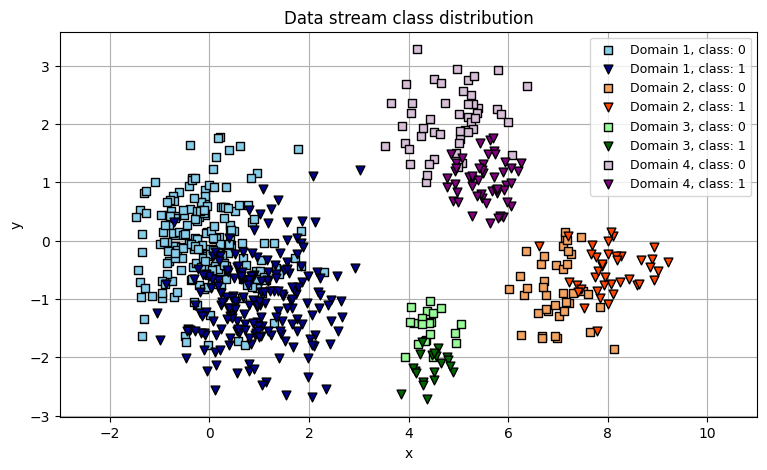

In [5]:
plot_class_distribution(X, save=True)

In [6]:
def split_dataframes_based_on_drift(X: pd.DataFrame,
                                    changes: list):
  list_of_change = changes.copy()
  split_dataframes = []
  start_index = 0
  end_index = 0
  list_of_change.append(len(X))
  if len(changes) < 1:
    return X
  else:
    for i in range(len(list_of_change)):
      end_index = list_of_change[i]
      split_dataframes.append(X[start_index:end_index])
      start_index=end_index
    return split_dataframes

In [7]:
def streaming_learning(X: pd.DataFrame,
                       model_1 = HoeffdingTreeClassifier(),
                       model_2 = HoeffdingAdaptiveTreeClassifier(),
                       x_cols = ["x", "y"],
                       y_col = ["class"]
                       ):
    all_predictions_HTC = []
    all_predictions_HATC = []
    x = X[x_cols]
    y = X[y_col]

    model_1 = compose.Pipeline(
    ('tree', model_1))
    model_2 = compose.Pipeline(
    ('tree', model_2))
    
    for xi, yi in stream.iter_pandas(x, y):

      #classical hoeffding tree classifier  
      y_pred = model_1.predict_one(xi)
      all_predictions_HTC.append(y_pred)
      model_1.learn_one(xi, yi[y_col[0]])

      #ensable hoeffding tree classifier 
      y_pred = model_2.predict_one(xi)
      all_predictions_HATC.append(y_pred)
      model_2.learn_one(xi, yi[y_col[0]])
    return all_predictions_HTC, all_predictions_HATC

### HTC and HATC streaming models

In [8]:
all_predictions_HTC, all_predictions_HATC = streaming_learning(X, model_1 = HoeffdingTreeClassifier(),  model_2 = HoeffdingAdaptiveTreeClassifier(), x_cols = ["x", "y"], y_col = ["class"])

In [9]:
def KLdivergence(x, y):
  """Compute the Kullback-Leibler divergence between two multivariate samples.
  Parameters
  ----------
  x : 2D array (n,d)
    Samples from distribution P, which typically represents the true
    distribution.
  y : 2D array (m,d)
    Samples from distribution Q, which typically represents the approximate
    distribution.
  Returns
  -------
  out : float
    The estimated Kullback-Leibler divergence D(P||Q).
  References
  ----------
  Pérez-Cruz, F. Kullback-Leibler divergence estimation of
continuous distributions IEEE International Symposium on Information
Theory, 2008.
  """


  # Check the dimensions are consistent
  x = np.atleast_2d(x)
  y = np.atleast_2d(y)

  n,d = x.shape
  m,dy = y.shape

  assert(d == dy)


  # Build a KD tree representation of the samples and find the nearest neighbour
  # of each point in x.
  xtree = KDTree(x)
  ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
  r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
  s = ytree.query(x, k=1, eps=.01, p=2)[0]

  # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
  # on the first term of the right hand side.
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

In [10]:
def distribution_drift_detection(X: pd.DataFrame,
                                 referance_samples = 100, 
                                 x_cols = ["x", "y"],
                                 min_instances=10,
                                 delta=0.05,
                                 threshold=4,
                                 alpha=0.9999,
                                 save=False
                                 
                                ):

    reference_distribution = X[x_cols][:referance_samples].values 
    X["KL"] = -1
    stream_change = []
    ph = PageHinkley(min_instances=min_instances, delta=delta, threshold=threshold, alpha=alpha)
    start_drift = 2
    referance_indx_start = referance_indx_end =  0
    
    for i in range(referance_samples, len(X)):
        sample =  X[x_cols].loc[i].values 
        kl_divergence = KLdivergence(reference_distribution, sample)
        X["KL"].loc[i] = kl_divergence
        ph.update(kl_divergence)
        if ph.drift_detected:
          stream_change.append(i)
          start_drift = i
          reference_distribution = X[x_cols][start_drift-2:i].values

        else:
            reference_distribution = X[x_cols][start_drift-2:i].values
    
    custom_colors =  ["darkblue", "orangered", "darkgreen", "purple", "saddlebrown", "dimgrey"]
    X_plot = X[referance_samples:]
    plt.figure(figsize=(9,5))
    for i in range(len(X_plot['cluster'].unique())):
        cluster = X_plot['cluster'].unique()[i]
        subset = X_plot[X_plot['cluster'] == cluster]
        plt.scatter(subset.index, subset['KL'], c=custom_colors[i],  edgecolors="k", label=f'Domain {i+1}')

    plt.axvline(x = stream_change[0], color = "#c73213", label = 'Detected change')
    for idx in stream_change:
        plt.axvline(x = idx, color = "#c73213")
    plt.ylabel("KL Divergence")
    plt.xlabel("sample")
    plt.title(f"Changes detected in samples: {stream_change}")
    plt.legend(loc='best')
    plt.grid()
    if save:
        plt.savefig(f"KL_{datetime.now()}.pdf", format="pdf", bbox_inches="tight")
    plt.show()



    return stream_change
        

### DETECTING DOMAIN SHIFTS USING KL AND PH

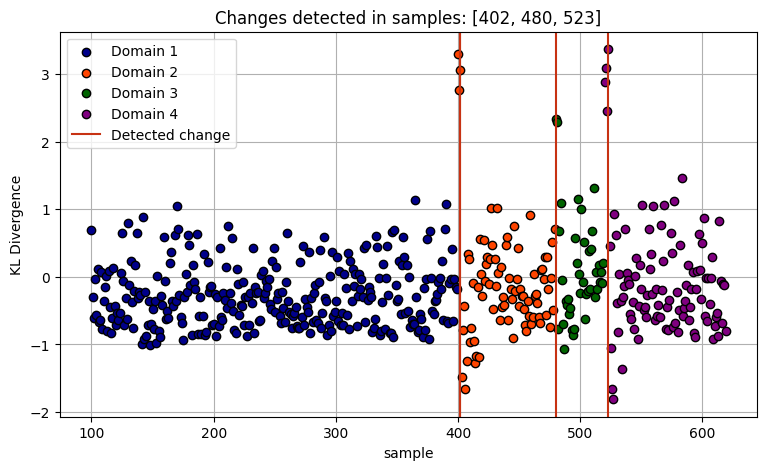

In [11]:
stream_change = distribution_drift_detection(X, referance_samples = 100, x_cols = ["x", "y"], min_instances=1, delta=0.005, threshold=15, alpha=0.9999, save=False)

## DOMAIN ADAPTATION ON DETECTED DRIFTS

### define CCSA models

In [12]:
x_cols = ["x", "y"]

def get_encoder(input_shape=(X[x_cols].shape[1],)):
    model = Sequential()
    model.add(Dense(10, activation='relu',
                    input_shape=input_shape))
    model.add(Dense(10, activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(2, activation="sigmoid"))
    model.compile(optimizer=Adam(lr=0.001), loss=BinaryFocalCrossentropy(gamma=1))
    return model

def get_task(input_shape=(X[x_cols].shape[1],)):
    model = Sequential()
    model.add(Dense(10, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(lr=0.001), loss=BinaryFocalCrossentropy(gamma=1))
    return model


ccsa_enc = get_encoder()
ccsa_task = get_task()



2024-03-17 12:32:51.399172: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-03-17 12:32:51.399192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 61091f34559d
2024-03-17 12:32:51.399196: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 61091f34559d
2024-03-17 12:32:51.399366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.86.10
2024-03-17 12:32:51.399379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.86.10
2024-03-17 12:32:51.399382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.86.10


In [13]:
def stream_domain_adaptation(X:pd.DataFrame,
                             ccsa_enc,
                             ccsa_task,
                             all_predictions_stream_HTC,
                             all_predictions_stream_HATC,
                             stream_change,
                             batch_size,      
                             x_cols = ["x", "y"],
                             y_col = ["class"]):


  


  print("---------------STREAMING LEARNING---------------")

  all_results_da_incremental = pd.DataFrame()
  all_results_da_simple = pd.DataFrame()
  result_info = pd.DataFrame()
  df_pred_da = pd.DataFrame()
  df_pred_darc = pd.DataFrame()
  df_pred_tree = pd.DataFrame()
  df_pred_forest = pd.DataFrame()
  df_pred_xgboost = pd.DataFrame()
    
  split_X = split_dataframes_based_on_drift(X, stream_change)
  data_source = split_X[0]
  print(f"CHANGES: {stream_change}")
  Xs = data_source[x_cols]
  ys = data_source[y_col].values
  training = 0


  stream_change.append(len(X))

  tree =  DecisionTreeClassifier(random_state=0)
  random_forest = RandomForestClassifier(random_state=0)
  xgboost = XGBClassifier(random_state=0)


  print("--------------- DOMAIN ADAPTATION - BATCHES ---------------")


  for i in range(0, len(split_X)-1):
    print(f"ITERATION : {i}")
    print(f"----------------------------------------")
    print(f"data source shape : {data_source.shape}")
    data_target = split_X[i+1]
    Xt = data_target[x_cols]
    yt = data_target[y_col].values
    print(f"Xt shape: {Xt.shape}, yt shape: {yt.shape}")
    
    callback = EarlyStopping(monitor='loss',patience=3)
    start_batch = stream_change[i]
    end_batch = start_batch + batch_size
    next_stream_change = stream_change[i+1]
    print(f"START_BATCH: {start_batch}, END_BATCH: {end_batch}, NEXT_CHANGE: {next_stream_change}")
    batch_training = 0  
    f1_source = 0
    da_retraining = 0


    while end_batch < next_stream_change:

      Xt_batch = X[x_cols][start_batch:end_batch]
      yt_batch = X[y_col][start_batch:end_batch].values
      print(f"X_source {Xs.shape}, y_source: {ys.shape}")
      print(f"X_target_batch {Xt_batch.shape}, y_target_batch: {yt_batch.shape}")
      print(f"start_X_target_batch_index: {start_batch}, end: {end_batch}")
      EPOCHS = 500
      INIT_LR = 0.001
      decay=INIT_LR / EPOCHS
      model = CCSA(ccsa_enc, ccsa_task, Xt=Xt_batch, yt=yt_batch, metrics=["acc"], loss=BinaryFocalCrossentropy(gamma=1,  apply_class_balancing=False, alpha=0.25), 
                   random_state=0, optimizer=Adam(learning_rate=INIT_LR))  #model initialization
      f1_source = 0
      da_retraining = 0

      while (f1_source < 0.5 and (da_retraining<5)):
          model.fit(X=Xs, y=ys, Xt=Xt_batch, yt=yt_batch, epochs=EPOCHS, batch_size=128, verbose=0, callbacks=[callback])
          y_predict_source = model.predict(Xs)[:,0]
          y_predict_source = list(map(lambda x: 1 if x>0.5 else 0, y_predict_source))
          f1_source = f1_score(y_predict_source, ys)
          print(f"f1 source : {f1_source}, training: {da_retraining}")
          da_retraining += 1

        
      print("tree fitting") 
      #decision tree
      tree.fit(X = pd.concat([Xs, Xt_batch]), y = np.concatenate((ys, yt_batch), axis=0))
      #ranodm_forest
      random_forest.fit(X = pd.concat([Xs, Xt_batch]), y = np.concatenate((ys, yt_batch), axis=0))  
      #xgboost
      xgboost.fit(X = pd.concat([Xs, Xt_batch]), y = np.concatenate((ys, yt_batch), axis=0))
      training = training + 1
    
      next_batch = end_batch + batch_size

      if next_batch < next_stream_change:

        Xt_next_batch = X[x_cols][end_batch:next_batch]
        yt_next_batch = X[y_col][end_batch:next_batch].values
        print(f"Xt_next_batch {Xt_next_batch.shape}, yt_next_batch: {yt_next_batch.shape}")
        y_predict_next_batch = model.predict(Xt_next_batch)[:,0]
        y_predict_next_batch = list(map(lambda x: 1 if x>0.5 else 0, y_predict_next_batch))
        df_pred = pd.DataFrame(data=y_predict_next_batch, columns=["y_pred_da"], index=Xt_next_batch.index)
        df_pred_da = pd.concat([df_pred_da, df_pred])
        print(f"y_predict_next_batch: {len(y_predict_next_batch)}")
        y_pred_stream_HTC = all_predictions_stream_HTC[end_batch:next_batch]
        y_pred_stream_HATC = all_predictions_stream_HATC[end_batch:next_batch]
        print(f"y_pred_stream_HTC: {len(y_pred_stream_HTC)}")
        print(f"y_pred_stream_HATC: {len(y_pred_stream_HATC)}")
        y_pred_tree = tree.predict(Xt_next_batch)
        df_pred = pd.DataFrame(data=y_pred_tree, columns=["y_pred_tree"], index=Xt_next_batch.index)
        df_pred_tree = pd.concat([df_pred_tree, df_pred])
        y_pred_forest = random_forest.predict(Xt_next_batch)  
        df_pred = pd.DataFrame(data=y_pred_forest, columns=["y_pred_forest"], index=Xt_next_batch.index)
        df_pred_forest = pd.concat([df_pred_forest, df_pred])  
        y_pred_xgboost = xgboost.predict(Xt_next_batch)  
        df_pred = pd.DataFrame(data=y_pred_xgboost, columns=["y_pred_xgboost"], index=Xt_next_batch.index)
        df_pred_xgboost = pd.concat([df_pred_xgboost, df_pred])  


        df_result = pd.DataFrame(data={
                          "data_source" : ['1'],
                          "data_target" : [f"{i+2}"],
                          "start_batch_fit" : [start_batch],
                          "end_batch_fit" : [end_batch],
                          "start_batch_predict" : [end_batch],
                          "end_batch_predict" : [end_batch + len(y_predict_next_batch)],
                          "len batch predicted" :  [len(y_predict_next_batch)],
                          "f1_da" : [f1_score(yt_next_batch, y_predict_next_batch)],
                          "f1_HTC" : [f1_score(yt_next_batch, y_pred_stream_HTC)],
                          "f1_HATC" : [f1_score(yt_next_batch, y_pred_stream_HATC)],
                          "f1_tree" : [f1_score(yt_next_batch, y_pred_tree)],
                          "f1_forest" : [f1_score(yt_next_batch, y_pred_forest)],
                          "f1_xgboost" : [f1_score(yt_next_batch, y_pred_xgboost)],  
                          "G_da" : [geometric_mean_score(yt_next_batch, y_predict_next_batch, average='binary')],
                          "G_HTC" : [geometric_mean_score(yt_next_batch, y_pred_stream_HTC, average='binary')],
                          "G_HATC" : [geometric_mean_score(yt_next_batch, y_pred_stream_HATC, average='binary')],
                          "G_tree" : [geometric_mean_score(yt_next_batch, y_pred_tree, average='binary')],
                          "G_forest" : [geometric_mean_score(yt_next_batch, y_pred_forest, average='binary')],
                          "G_xgboost" : [geometric_mean_score(yt_next_batch, y_pred_xgboost, average='binary')],
                          "accuracy_da" : [accuracy_score(yt_next_batch, y_predict_next_batch)],
                          "accuracy_HTC" : [accuracy_score(yt_next_batch, y_pred_stream_HTC)],
                          "accuracy_HATC" : [accuracy_score(yt_next_batch, y_pred_stream_HATC)],
                          "accuracy_tree" : [accuracy_score(yt_next_batch, y_pred_tree)],
                          "accuracy_forest" : [accuracy_score(yt_next_batch, y_pred_forest)],
                          "accuracy_xgboost" : [accuracy_score(yt_next_batch, y_pred_xgboost)],  
                          "precision_da" : [precision_score(yt_next_batch, y_predict_next_batch)],
                          "precision_HTC" : [precision_score(yt_next_batch, y_pred_stream_HTC)],
                          "precision_HATC" : [precision_score(yt_next_batch, y_pred_stream_HATC)],
                          "precision_tree" : [precision_score(yt_next_batch, y_pred_tree)],
                          "precision_forest" : [precision_score(yt_next_batch, y_pred_forest)],
                          "precision_xgboost" : [precision_score(yt_next_batch, y_pred_xgboost)],  
                          "recall_da" : [recall_score(yt_next_batch, y_predict_next_batch)],
                          "recall_HTC" : [recall_score(yt_next_batch, y_pred_stream_HTC)],
                          "recall_HATC" : [recall_score(yt_next_batch, y_pred_stream_HATC)],
                          "recall_tree" : [recall_score(yt_next_batch, y_pred_tree)],
                          "recall_forest" : [recall_score(yt_next_batch, y_pred_forest)],
                          "recall_xgboost" : [recall_score(yt_next_batch, y_pred_xgboost)]
                          })

        result_info = pd.concat([result_info, df_result])
        end_batch = next_batch

      else:
        
        Xt_next_batch = X[x_cols][end_batch:next_stream_change]
        yt_next_batch = X[y_col][end_batch:next_stream_change].values
        print(f'X_next_batch shape: {Xt_next_batch.shape}')
        y_predict_next_batch= model.predict(Xt_next_batch)[:,0]
    
          
        y_predict_next_batch = list(map(lambda x: 1 if x>0.5 else 0, y_predict_next_batch))
        df_pred = pd.DataFrame(data=y_predict_next_batch, columns=["y_pred_da"], index=Xt_next_batch.index)
        df_pred_da = pd.concat([df_pred_da, df_pred])
        y_pred_stream_HTC = all_predictions_stream_HTC[end_batch:next_stream_change]
        y_pred_stream_HATC = all_predictions_stream_HATC[end_batch:next_stream_change]
          
        y_pred_tree = tree.predict(Xt_next_batch)
        df_pred = pd.DataFrame(data=y_pred_tree, columns=["y_pred_tree"], index=Xt_next_batch.index)
        df_pred_tree = pd.concat([df_pred_tree, df_pred])
        y_pred_forest = random_forest.predict(Xt_next_batch)  
        df_pred = pd.DataFrame(data=y_pred_forest, columns=["y_pred_forest"], index=Xt_next_batch.index)
        df_pred_forest = pd.concat([df_pred_forest, df_pred])  
        y_pred_xgboost = xgboost.predict(Xt_next_batch)  
        df_pred = pd.DataFrame(data=y_pred_xgboost, columns=["y_pred_xgboost"], index=Xt_next_batch.index)
        df_pred_xgboost = pd.concat([df_pred_xgboost, df_pred])    

        df_result = pd.DataFrame(data={
                          "data_source" : ['1'],
                          "data_target" : [f"{i+2}"],
                          "start_batch_fit" : [start_batch],
                          "end_batch_fit" : [end_batch],
                          "start_batch_predict" : [end_batch],
                          "end_batch_predict" : [end_batch + len(y_predict_next_batch)],
                          "len batch predicted" :  [len(y_predict_next_batch)],
                          "f1_da" : [f1_score(yt_next_batch, y_predict_next_batch)],
                          "f1_HTC" : [f1_score(yt_next_batch, y_pred_stream_HTC)],
                          "f1_HATC" : [f1_score(yt_next_batch, y_pred_stream_HATC)],
                          "f1_tree" : [f1_score(yt_next_batch, y_pred_tree)],
                          "f1_forest" : [f1_score(yt_next_batch, y_pred_forest)],
                          "f1_xgboost" : [f1_score(yt_next_batch, y_pred_xgboost)],  
                          "G_da" : [geometric_mean_score(yt_next_batch, y_predict_next_batch, average='binary')],
                          "G_HTC" : [geometric_mean_score(yt_next_batch, y_pred_stream_HTC, average='binary')],
                          "G_HATC" : [geometric_mean_score(yt_next_batch, y_pred_stream_HATC, average='binary')],
                          "G_tree" : [geometric_mean_score(yt_next_batch, y_pred_tree, average='binary')],
                          "G_forest" : [geometric_mean_score(yt_next_batch, y_pred_forest, average='binary')],
                          "G_xgboost" : [geometric_mean_score(yt_next_batch, y_pred_xgboost, average='binary')],
                          "accuracy_da" : [accuracy_score(yt_next_batch, y_predict_next_batch)],
                          "accuracy_HTC" : [accuracy_score(yt_next_batch, y_pred_stream_HTC)],
                          "accuracy_HATC" : [accuracy_score(yt_next_batch, y_pred_stream_HATC)],
                          "accuracy_tree" : [accuracy_score(yt_next_batch, y_pred_tree)],
                          "accuracy_forest" : [accuracy_score(yt_next_batch, y_pred_forest)],
                          "accuracy_xgboost" : [accuracy_score(yt_next_batch, y_pred_xgboost)],  
                          "precision_da" : [precision_score(yt_next_batch, y_predict_next_batch)],
                          "precision_HTC" : [precision_score(yt_next_batch, y_pred_stream_HTC)],
                          "precision_HATC" : [precision_score(yt_next_batch, y_pred_stream_HATC)],
                          "precision_tree" : [precision_score(yt_next_batch, y_pred_tree)],
                          "precision_forest" : [precision_score(yt_next_batch, y_pred_forest)],
                          "precision_xgboost" : [precision_score(yt_next_batch, y_pred_xgboost)],  
                          "recall_da" : [recall_score(yt_next_batch, y_predict_next_batch)],
                          "recall_HTC" : [recall_score(yt_next_batch, y_pred_stream_HTC)],
                          "recall_HATC" : [recall_score(yt_next_batch, y_pred_stream_HATC)],
                          "recall_tree" : [recall_score(yt_next_batch, y_pred_tree)],
                          "recall_forest" : [recall_score(yt_next_batch, y_pred_forest)],
                          "recall_xgboost" : [recall_score(yt_next_batch, y_pred_xgboost)]
                          })

        result_info = pd.concat([result_info, df_result])
        break


    df_pred_stream_HTC = pd.DataFrame(data=all_predictions_stream_HTC, columns=["y_pred_stream_HTC"], index=X.index)
    df_pred_stream_HATC = pd.DataFrame(data=all_predictions_stream_HATC, columns=["y_pred_stream_HATC"], index=X.index)
    df_true = pd.DataFrame(data=X[y_col].values, columns=["y_true"], index=X.index)
    df_da = pd.merge(df_pred_da, df_pred_stream_HTC, left_index=True, right_index=True)
    df_da = pd.merge(df_da, df_pred_stream_HATC, left_index=True, right_index=True)
    df_stream_da = pd.merge(df_da, df_true, left_index=True, right_index=True)
    df_stream_da = pd.merge(df_stream_da, df_pred_tree, left_index=True, right_index=True) 
    df_stream_da = pd.merge(df_stream_da, df_pred_forest, left_index=True, right_index=True) 
    df_stream_da = pd.merge(df_stream_da, df_pred_xgboost, left_index=True, right_index=True) 

  return result_info, df_stream_da

In [14]:
batch_size=20 #define the batch size for trainig domain adaptation

In [15]:
res, df_stream_da = stream_domain_adaptation(X, ccsa_enc, ccsa_task, all_predictions_HTC, all_predictions_HATC, stream_change, batch_size = batch_size, x_cols = ["x", "y"], y_col = ["class"])

---------------STREAMING LEARNING---------------
CHANGES: [402, 480, 523]
--------------- DOMAIN ADAPTATION - BATCHES ---------------
ITERATION : 0
----------------------------------------
data source shape : (402, 5)
Xt shape: (78, 2), yt shape: (78, 1)
START_BATCH: 402, END_BATCH: 422, NEXT_CHANGE: 480
X_source (402, 2), y_source: (402, 1)
X_target_batch (20, 2), y_target_batch: (20, 1)
start_X_target_batch_index: 402, end: 422
f1 source : 0.8530120481927711, training: 0
tree fitting
Xt_next_batch (20, 2), yt_next_batch: (20, 1)
y_predict_next_batch: 20
y_pred_stream_HTC: 20
y_pred_stream_HATC: 20
X_source (402, 2), y_source: (402, 1)
X_target_batch (40, 2), y_target_batch: (40, 1)
start_X_target_batch_index: 402, end: 442
f1 source : 0.8369829683698298, training: 0
tree fitting
Xt_next_batch (20, 2), yt_next_batch: (20, 1)
y_predict_next_batch: 20
y_pred_stream_HTC: 20
y_pred_stream_HATC: 20
X_source (402, 2), y_source: (402, 1)
X_target_batch (60, 2), y_target_batch: (60, 1)
start_

In [16]:
res.describe()

,start_batch_fit,end_batch_fit,start_batch_predict,end_batch_predict,len batch predicted,f1_da,f1_HTC,f1_HATC,f1_tree,f1_forest,f1_xgboost,G_da,G_HTC,G_HATC,G_tree,G_forest,G_xgboost,accuracy_da,accuracy_HTC,accuracy_HATC,accuracy_tree,accuracy_forest,accuracy_xgboost,precision_da,precision_HTC,precision_HATC,precision_tree,precision_forest,precision_xgboost,recall_da,recall_HTC,recall_HATC,recall_tree,recall_forest,recall_xgboost
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,473.111111,515.333333,515.333333,532.888889,17.555556,0.707058,0.270629,0.504398,0.795936,0.829557,0.842360,0.487100,0.027778,0.336140,0.671171,0.703652,0.722348,0.666558,0.428068,0.638308,0.799782,0.828540,0.836674,0.659428,0.208660,0.592256,0.780556,0.808179,0.815500,0.824074,0.398148,0.550926,0.839506,0.881173,0.900617
std,56.148118,63.729899,63.729899,63.510717,5.570258,0.302677,0.326334,0.363098,0.163965,0.133078,0.116775,0.467076,0.083333,0.344877,0.294774,0.298286,0.297015,0.328215,0.195463,0.228845,0.164832,0.143324,0.130253,0.331345,0.256988,0.415046,0.201470,0.188071,0.196781,0.334489,0.478310,0.436893,0.162285,0.130864,0.079261
min,402.000000,422.000000,422.000000,442.000000,3.000000,0.000000,0.000000,0.000000,0.600000,0.666667,0.720000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,0.550000,0.600000,0.650000,0.000000,0.000000,0.000000,0.500000,0.533333,0.562500,0.000000,0.000000,0.000000,0.500000,0.666667,0.800000
25%,402.000000,462.000000,462.000000,480.000000,18.000000,0.620690,0.000000,0.285714,0.608696,0.720000,0.736842,0.000000,0.000000,0.000000,0.531816,0.603023,0.696311,0.450000,0.350000,0.450000,0.764706,0.750000,0.750000,0.450000,0.000000,0.363636,0.700000,0.666667,0.636364,0.750000,0.000000,0.166667,0.777778,0.750000,0.833333
50%,480.000000,520.000000,520.000000,523.000000,20.000000,0.800000,0.000000,0.545455,0.777778,0.823529,0.842105,0.750000,0.000000,0.408248,0.810093,0.778499,0.763763,0.750000,0.450000,0.700000,0.800000,0.833333,0.850000,0.666667,0.000000,0.600000,0.750000,0.800000,0.888889,1.000000,0.000000,0.500000,0.875000,0.888889,0.875000
75%,523.000000,563.000000,563.000000,583.000000,20.000000,0.900000,0.620690,0.750000,0.933333,0.965517,0.909091,0.904534,0.000000,0.612372,0.816497,0.866025,0.912871,0.900000,0.555556,0.750000,0.900000,0.950000,0.941176,0.933333,0.450000,1.000000,1.000000,1.000000,1.000000,1.000000,0.833333,1.000000,1.000000,1.000000,1.000000
max,523.000000,603.000000,603.000000,620.000000,20.000000,1.000000,0.714286,1.000000,1.000000,1.000000,1.000000,1.000000,0.250000,0.874007,1.000000,1.000000,1.000000,1.000000,0.647059,1.000000,1.000000,1.000000,1.000000,1.000000,0.625000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
y_true = df_stream_da["y_true"]
y_pred_da = df_stream_da["y_pred_da"]
print(f"F1 score: {f1_score(y_true, y_pred_da)}")
print(f"G score : {geometric_mean_score(y_true, y_pred_da)}")
print(f"accuracy : {accuracy_score(y_true, y_pred_da)}")
print(f"precision: {precision_score(y_true, y_pred_da)}")
print(f"recall: {recall_score(y_true, y_pred_da)}")

F1 score: 0.7741935483870968
G score : 0.71246821668204
accuracy : 0.7341772151898734
precision: 0.6728971962616822
recall: 0.9113924050632911
